<a href="https://colab.research.google.com/github/utensil/llm-playground/blob/main/notebooks/transformer-agent-starcoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers can do anything

Transformers version v4.29 introduces a new API: an API of **tools** and **agents** 🤩

It provides a natural language API on top of transformers: we define a set of curated tools, and design an agent to interpret natural language and to use these tools. It is extensible by design; we curated some relevant tools, but we'll show you how the system can be extended easily to use any tool.

Let's start with a few examples of what can be achieved with this new API. It is particularly powerful when it comes to multimodal tasks, so let's take it for a spin to generate images and read text out loud.

The accompanying docs are [Transformers Agent](https://huggingface.co/docs/transformers/en/transformers_agents) and [Custom Tools](https://huggingface.co/docs/transformers/en/custom_tools).

In [1]:
#@title Setup
transformers_version = "v4.29.0" #@param ["main", "v4.29.0"] {allow-input: true}

print(f"Setting up everything with transformers version {transformers_version}")

!pip install huggingface_hub>=0.14.1 git+https://github.com/huggingface/transformers@$transformers_version -q diffusers accelerate datasets torch soundfile sentencepiece opencv-python openai

import IPython
import soundfile as sf

def play_audio(audio):
    sf.write("speech_converted.wav", audio.numpy(), samplerate=16000)
    return IPython.display.Audio("speech_converted.wav")

from huggingface_hub import notebook_login
notebook_login()

Setting up everything with transformers version v4.29.0


# Do anything with Transformers

We'll start by instantiating an **agent**, which is a large language model (LLM). 

We recommend using the OpenAI for the best results, but fully open-source models such as StarCoder or OpenAssistant are also available.

In [2]:
#@title Agent init
agent_name = "StarCoder (HF Token)" #@param ["StarCoder (HF Token)", "OpenAssistant (HF Token)", "OpenAI (API Key)"]

import getpass

if agent_name == "StarCoder (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder")
    print("StarCoder is initialized 💪")
elif agent_name == "OpenAssistant (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent(url_endpoint="https://api-inference.huggingface.co/models/OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5")
    print("OpenAssistant is initialized 💪")
if agent_name == "OpenAI (API Key)":
    from transformers.tools import OpenAiAgent
    pswd = getpass.getpass('OpenAI API key:')
    agent = OpenAiAgent(model="text-davinci-003", api_key=pswd)
    print("OpenAI is initialized 💪")

StarCoder is initialized 💪


## Using the agent

The agent is initialized! We now have access to the full power of the tools it has access to.

Let's use it 😎

==Explanation from the agent==
I will use the following  tool: `image_generator` to generate an image.


==Code generated by the agent==
image = image_generator(prompt="a boat in the water")


==Result==


A new version of the following files was downloaded from https://huggingface.co/space/huggingface-tools/text-to-image:
- text_to_image.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

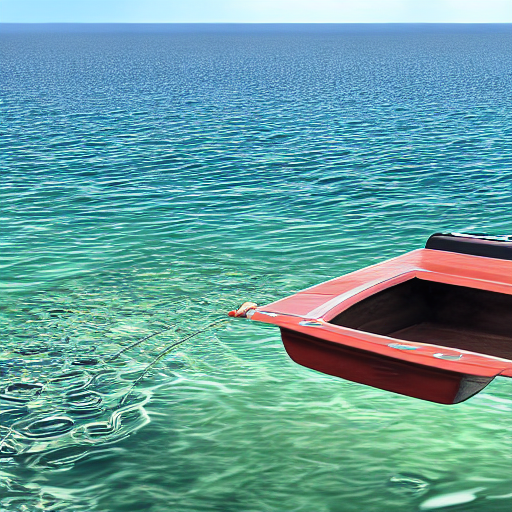

In [3]:
boat = agent.run("Generate an image of a boat in the water")
boat

If you'd like to hand objects (or previous results!) to the agent, you can do so by passing a variable directly, and mentioning between backticks the name of the variable passed. For example, if I want to re-use the previous boat generation:

In [4]:
caption = agent.run("Can you caption the `boat_image`?", boat_image=boat)
caption

==Explanation from the agent==
I will use the following  tool: `image_captioner` to generate a caption for the image.


==Code generated by the agent==
caption = image_captioner(boat_image)


==Result==


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'a boat floating in the ocean with a blue sky'

Agents vary in competency and their capacity to handle several instructions at once; however the strongest of them (such as OpenAI's) are able to handle complex instructions such as the following three-part instruction:

In [ ]:
audio = agent.run("Can you generate an image of a boat? Please read out loud the contents of the image afterwards")
play_audio(audio)

Where this works great is when your query implies the use of tools which you haven't described directly. An exemple of this would be the following query: "Read out loud the summary of hf.co"

Here we're asking the model to perform three steps at once:
- Fetch the website https://huggingface.co
- Summarize it
- Translate the text to speech

### Chat mode

So far, we've been using the agent by using it's `.run` command. But that's not the only command it has access to; the second command it has access to is `.chat`, which enables using it in chat mode.

The difference between the two is relative to their memory:
- `.run` does not keep memory across runs, but performs better for multiple operations at once (such as running two, or three tools in a row from a given instruction)
- `.chat` keeps memory across runs, but performs better at single instructions.

Let's use it in chat mode!

==Explanation from the agent==
I will use the tool `image_generator` to generate an image with a parameter prompt: a cat.


==Code generated by the agent==
image = image_generator(prompt="a cat")


==Result==


  0%|          | 0/25 [00:00<?, ?it/s]

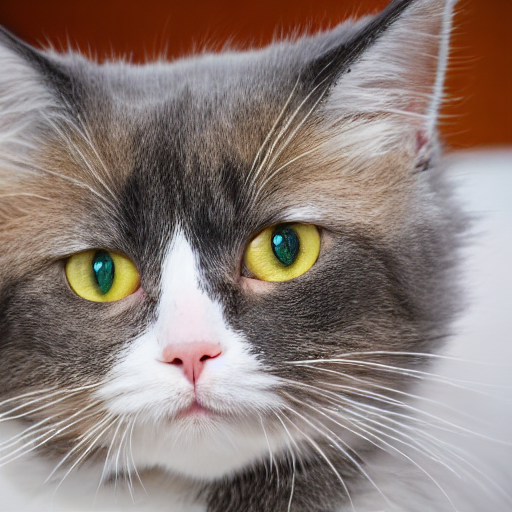

In [26]:
agent.chat("Generate a picture with a parameter prompt: a cat")

What if we wanted to change something in the image? For example, move the capybaras to a snowy environment

==Explanation from the agent==
I will use the tool `image_transformer` to transform the image.


==Code generated by the agent==
transformed_image = image_transformer(image, prompt="astronaut")


==Result==


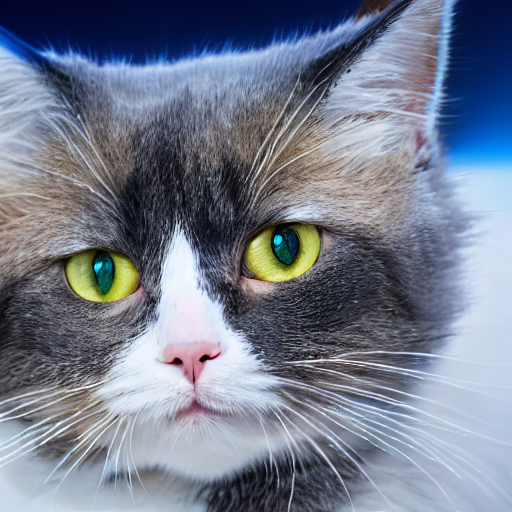

In [29]:
agent.chat("Transform the image so that it is like an astronaut")

Now what if we wanted to remove the capybara in favor of something else? We could ask it to show us a mask of the capybara in the image:

==Explanation from the agent==
I will use the tool `image_segmenter` to create a mask of the cat.


==Code generated by the agent==
mask = image_segmenter(image, label="cat")


==Result==


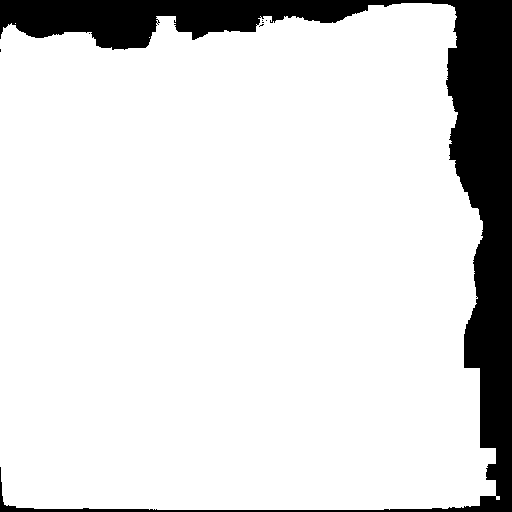

In [30]:
agent.chat("Show me a mask of the cat")

Having access to the past history is great to repeatedly iterate on a given prompt. However, it has its limitations and sometimes you'd like to have a clean history. In order to do so, you can use the following method:

In [31]:
agent.prepare_for_new_chat()

==Explanation from the agent==
I will use the tool `image_generator` to generate an image of a cat.


==Code generated by the agent==
image = image_generator(prompt="a cat")


==Result==


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

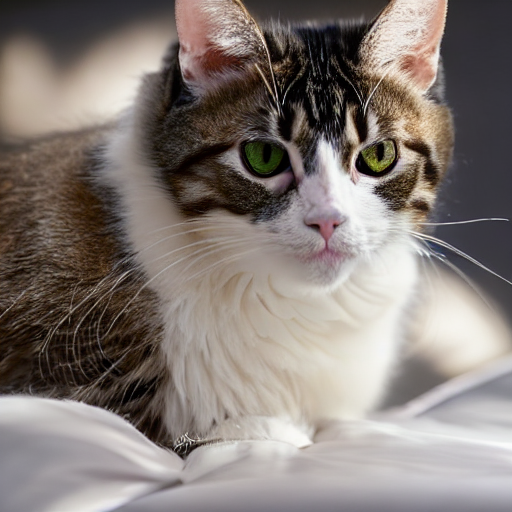

In [32]:
agent.chat("Generate a picture of a cat")

==Explanation from the agent==
I will use the tool `image_segmenter` to segment the image of a cat, then the tool `image_transformer` to transform the image of a cat.


==Code generated by the agent==
cat_mask = image_segmenter(image, label="cat")
cat_image = image_transformer(image, prompt="a cat with the feeling of sci-fi")


==Result==


  0%|          | 0/50 [00:00<?, ?it/s]

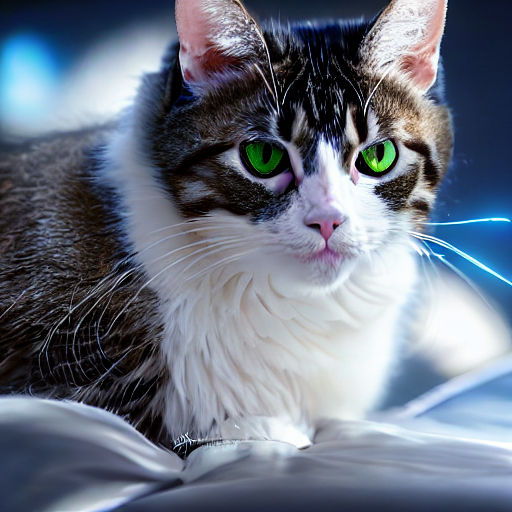

In [34]:
agent.chat("show me a picture of a cat with the feeling of sci-fi")